In [447]:
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import regex as re
from nltk.corpus import stopwords
import pandas as pd

In [ ]:
# Import data from json file with uft-8 encoding so that \xa0 is not a problem. 
with open('/Users/adamwagnerhoegh/Documents/Legal data/domsdatabasen.retsinformation_newer.json', encoding = 'utf-8') as f:
    retsinfo = json.load(f)
# Replace \xa0 with a space in the loaded data
def replace_nbsp(obj):
    if isinstance(obj, dict):
        return {k: replace_nbsp(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [replace_nbsp(i) for i in obj]
    elif isinstance(obj, str):
        return obj.replace('\xa0', ' ')
    else:
        return obj

retsinfo = replace_nbsp(retsinfo)

In [ ]:
# A key is called "shortName" and contains the law number.
def inspect_a_law(law_number_shortname):
    for law in retsinfo:
        if law['shortName'] == law_number_shortname:
            return law
        
def get_paragraph(law, paragraph_number):
    for chapter in law['kapitler']:
        for paragraph in chapter['paragraffer']:
            if paragraph['nummer'] == f'§ {paragraph_number}.':
                # Print index for chapter and paragraph
                print(f'Chapter: {law["kapitler"].index(chapter)}')
                print(f'Paragraph: {chapter["paragraffer"].index(paragraph)}')
                return paragraph

law = inspect_a_law('LBK nr 928 af 28/06/2024')
paragraph = get_paragraph(law, '45 d')
paragraph

Chapter: 13
Paragraph: 6


{'nummer': '§ 45 d.',
 'index': 6,
 'stk': [{'tekst': 'Se note 2. Se note 2. virksomheder, der indsamler affald, virksomheder, der indsamler affald, affaldstransportører, anlæg, der behandler genanvendeligt erhvervsaffald, forhandlere og mæglere af affald og personer, der har bevis for at kunne forestå indberetning af data og miljømæssig forsvarlig håndtering af affaldet, jf. § 7, stk. 3, nr. 4.',
   'index': 0},
  {'tekst': 'Klima-, energi- og forsyningsministeren kan endvidere fastsætte regler om virksomheders, anlægs, transportørers, forhandleres og mægleres og personers pligt til at tilmelde sig registrene og om deres pligt til at indberette oplysninger hertil.',
   'index': 1}]}

In [369]:
# Inspecting the structure
retsinfo[0]['kapitler'][0]['paragraffer']

[{'nummer': '§ 1.',
  'index': 0,
  'stk': [{'tekst': 'Formålet med denne lov er at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre med tilknytning til arbejdsmarkedet ret til barselsdagpenge under fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov og at sikre ret til dagpenge ved pasning af alvorligt syge børn m.v.',
    'index': 0}]}]

In [370]:
# Inspecting the structure
retsinfo[0]['kapitler'][0]

{'nummer': 'Kapitel 1',
 'titel': 'Formål',
 'paragraffer': [{'nummer': '§ 1.',
   'index': 0,
   'stk': [{'tekst': 'Formålet med denne lov er at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre med tilknytning til arbejdsmarkedet ret til barselsdagpenge under fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov og at sikre ret til dagpenge ved pasning af alvorligt syge børn m.v.',
     'index': 0}]}]}

In [371]:
# Inspecting the structure
retsinfo[0]['kapitler'][0]['paragraffer'][0]['stk'][0]['tekst']

'Formålet med denne lov er at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre ret til fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov m.v. og at sikre forældre med tilknytning til arbejdsmarkedet ret til barselsdagpenge under fravær i forbindelse med graviditet, fødsel, adoption, herunder midlertidig placering, og sorgorlov og at sikre ret til dagpenge ved pasning af alvorligt syge børn m.v.'

In [372]:
# Inspecting
retsinfo[0]['kapitler'][1]['paragraffer'][0]

{'nummer': '§ 2.',
 'index': 0,
 'stk': [{'tekst': 'Ret til fravær efter denne lov omfatter alle forældre.',
   'index': 0},
  {'tekst': 'Dagpenge efter denne lov ydes i form af barselsdagpenge til lønmodtagere og selvstændige erhvervsdrivende.',
   'index': 1},
  {'tekst': 'Det er en betingelse for retten til barselsdagpenge for de personer, som er nævnt i stk. 2, at personen opfylder beskæftigelseskravet efter § 27 for lønmodtagere eller § 28 for selvstændige erhvervsdrivende.',
   'index': 2},
  {'tekst': 'Barselsdagpenge, som lønmodtagere har ret til efter stk. 2 og 3, kan udbetales til arbejdsgivere, der har udbetalt løn under fraværet, jf. § 39, stk. 1.',
   'index': 3},
  {'tekst': 'Beskæftigelsesministeren fastsætter særlige regler om barselsdagpenge til søfarende.',
   'index': 4}]}

In [373]:
retsinfo[0].keys()

dict_keys(['_id', 'AccessionNumber', 'DocumentTitle', 'Year', 'DiesSigni', 'Status', 'PopularTitle', 'Number', 'Ministry', 'UniqueDocumentId', 'changes', 'kapitler', 'Dato', 'url', 'dokumentType', 'shortName'])

In [374]:
retsinfo[0]['shortName']

'LBK nr 1069 af 25/09/2024'

In [375]:
# Ide: tjek længder af paragraffer. Hvis de er omkring 450 tokens kan det være at det kun er en af gangen der skal retrieves.
# Hvis det er tilfældet kan du måske frasortere alle paragraffer der er længere end 512 minus 50 tokens (context window minus maks længde genereret tekst)

rag_list = []

idx = 0

for lov in tqdm(retsinfo):
    for kapitel in lov['kapitler']:
        lov_navn = lov['shortName']
        for paragraffer in kapitel['paragraffer']:
            temp_paragraf_dict = {}
            temp_paragraf_dict['paragraf_nr'] = paragraffer['nummer']
            temp_paragraf_dict['lovnavn'] = lov_navn
            temp_paragraf_list = []
            for styk in paragraffer['stk']:
                temp_paragraf_list.append(styk['tekst'])
            temp_paragraf_dict['text'] = ' '.join(temp_paragraf_list)
            rag_list.append(temp_paragraf_dict)

100%|██████████| 1637/1637 [00:00<00:00, 26463.05it/s]


In [376]:
rag_list[5000]

{'paragraf_nr': '§ 34.',
 'lovnavn': 'LBK nr 807 af 21/06/2024',
 'text': 'Finanstilsynet kan fastsætte regler om foranstaltninger i forhold til lande og territorier med henblik på at opfylde krav eller anbefalinger fra Financial Action Task Force.'}

In [377]:
# Tokenizing all the paragraffer to see how long they generally are

from transformers import AutoTokenizer, T5ForConditionalGeneration

# Load the pretrained T5 model and tokenizer
model_name = "strombergnlp/dant5-large"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


/Users/adamwagnerhoegh/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [378]:
# Creating a function to tokenize

#max_length = 512-50

def count_tokens(list):
    temp_list = []
    for item in tqdm(list):
        temp_list.append(len(tokenizer(item, return_tensors="pt", padding=True, truncation=True)['input_ids'][0]))
    return temp_list


In [379]:
# Creating the skeleton for the function with an example

len(tokenizer(rag_list[0]['text'], return_tensors="pt")['input_ids'][0])

104

In [380]:
# Creating a list of the token_lengths

test_list = [item['text'] for item in rag_list]

len_tokens = count_tokens(test_list)

100%|██████████| 42593/42593 [00:13<00:00, 3105.74it/s]


In [381]:
len(rag_list)

42593

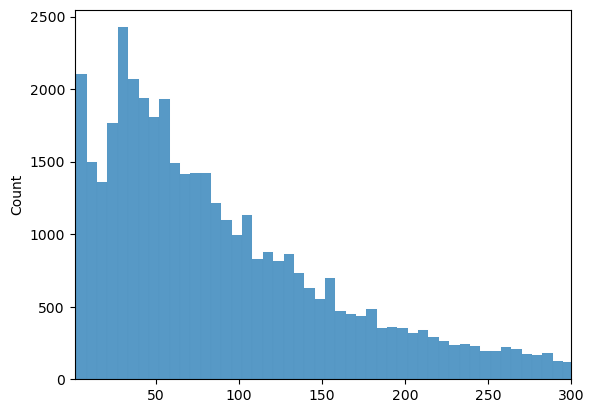

In [382]:
# Plotting the distribution of the text token lengths. This is important for RAG, as the documents being retrieved there will be on paragraf-level

fig, ax = plt.subplots()
sns.histplot(len_tokens, ax=ax)
ax.set_xlim(1, 300)
plt.show()

In [383]:
# Saving lists as txt-files

with open("rag_list.txt", "w") as file:
    for item in rag_list:
        file.write(f"{item}\n")

In [384]:
subset = rag_list[28395:]

In [385]:
# Sampling paragraphs to pick for question-answer pairs
import random
subset2 = random.sample(subset, 150)

In [386]:
subset2[149]

{'paragraf_nr': '§ 91.',
 'lovnavn': 'LBK nr 984 af 20/09/2019',
 'text': 'En erhvervsdrivende fond kan efter bestemmelserne i dette kapitel opløses uden likvidation ved overdragelse af fondens aktiver og forpligtelser som helhed til en anden erhvervsdrivende fond. En erhvervsdrivende fond kan ophøre ved fusion efter stk. 1, hvis den fortsættende fonds formål er beslægtet med den ophørende fonds formål og den ophørende fonds formål vil blive væsentlig bedre varetaget ved fusionen eller vil blive væsentlig bedre varetaget ved fusionen eller ikke længere eller kun vanskeligt kan opfyldes eller er blevet uhensigtsmæssigt. En erhvervsdrivende fond kan deltage i en fusion efter stk. 1 som den fortsættende fond, når fusionen ikke strider mod fondens vedtægt og fusionen ikke strider mod fondens vedtægt og fusionen må antages at være i fondens interesse. Bestyrelsen i hver af de fusionerende fonde træffer beslutning om fusion med forbehold for fondsmyndighedens tilladelse i henhold til § 96. H

In [387]:
subset2[141]['text']

'Ved grove eller gentagne overtrædelser af denne lov kan der ske konfiskation af det ved overtrædelsen anvendte motordrevne køretøj, hvortil der kræves kørekort, hvis det må anses for påkrævet for at forebygge yderligere overtrædelser af loven. Konfiskation skal ske, hvis ejeren af køretøjet har gjort sig skyldig i spirituskørsel med en promille over 1,20, der medfører ubetinget frakendelse af førerretten, og den pågældende to gange tidligere, inden for de seneste 3 år før det nye forhold er begået, har gjort sig skyldig i spirituskørsel med en promille over 1,20, der har medført ubetinget frakendelse af førerretten. Konfiskation efter stk. 2 skal ske, selv om køretøjet ikke er anvendt ved den aktuelle overtrædelse. Bestemmelsen i stk. 2 kan fraviges, når særlige grunde undtagelsesvis taler herfor. I øvrigt gælder reglerne om konfiskation i kriminalloven for Grønland.'

In [ ]:
# Vectorising paragraphs

rag_list2 = rag_list

vectorizer = TfidfVectorizer()

corpus = [item['text'] for item in rag_list]

# Stem or lemmatize here?

# lowercase
corpus = [item.lower() for item in corpus]

# remove special signs
corpus = [re.sub('\\W|[0-9]|§', ' ', item) for item in corpus]

# remove double (or more) whitespaces
corpus = [re.sub('\\s{2,}', ' ', item) for item in corpus]

# the step below removes very few words from the final document-feature matrix,
# and TF-IDF might solve the stop word problem indirectly. So perhaps
# we should just omit it, couldn't get the nltk word_tokenize to work anyway, 
# so I just used .split() (with whitespaces)

# # tokenize and remove stop words (is this necessary when using TF-IDF?)
# nltk.download('punkt')
# stop_words = set(stopwords.words('danish'))
# corpus = [' '.join([word for word in item.split() if word not in stop_words]) for item in tqdm(corpus)]


X = vectorizer.fit_transform(corpus)
